<a href="https://colab.research.google.com/github/Hasim-dev/MNIST-Digit-Recognition/blob/master/MNIST_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
# torchvision "MNIST"i içeriyor

In [0]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ]) # transform'u oluşturduk. ToTensor ve Normalize ile tensora dönüştürdük ve normalize ettik

# /data içine data'yı koy, train_set oluştur, indir, transform'u koy
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# epoch için tek seferde 60.000 image fazla olur. "batch_size" ile bölüyoruz. "shuffle" global minimum içindi.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [0]:
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.clone().detach().numpy() 
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  
  #Mormalizing the image mader our image -1 to 1. To ensure that the image is 0 to 1.
  image = image.clip(0, 1)
  
  return image

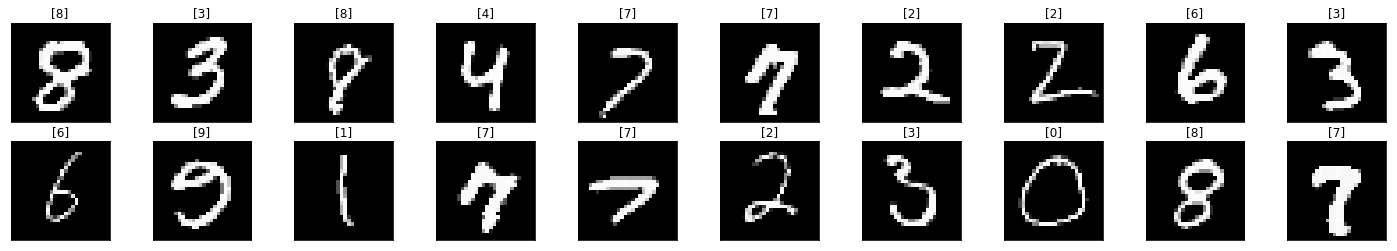

In [0]:
dataiter = iter(training_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title([labels[idx].item()]) #her image için title

In [0]:
class Classifier(nn.Module):
  # hidden layer sayısı, argument sayısını belirler. input, D1, D2, output layerindaki node sayısı argument olarak verilir.
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    
    # multiclass clf. olduğu için relu'ya sokulmuyor. 
    # "raw" (score) olarak çıkıyor. nn.CrossEntropyLoss hesaplamak için gerekiyor
    x = (self.linear3(x)) # buradan çıkan sonuca "activ. func." uygulanmmadı.
    return x

In [0]:
model = Classifier(784, 125, 65, 10) # sırayla; inout node, h1 layer node, h2 layer node, output node sayısı
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels) # output ve labellar karşılaştırılıyor.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # gelen outputlardan max değerli olanı alıyoruz.
    # ilk değer max score, ikinci değer max score'un index değerini döndürüyor.
    _, preds = torch.max(outputs, 1) 
    running_loss += loss.item()
    # single batch of images'da doğru prediction sayısını veriyor.
    running_corrects += torch.sum(preds == labels.data) 
        
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1) 
        val_running_loss += val_loss.item()
        # single batch of images'da doğru prediction sayısını veriyor.
        val_running_corrects += torch.sum(val_preds == val_labels.data) 
    
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss) #epoch_loss, listeye eklendi.
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch', (e+1))
    print('Training Loss: {:.4f}, acc {:.4f}' .format(epoch_loss, epoch_acc.item()))
    print('Validation Loss: {:.4f}, acc {:.4f}' .format(val_epoch_loss, val_epoch_acc.item()))
    

epoch 1
Training Loss: 0.9434, acc 77.7400
Validation Loss: 0.4211, acc 88.4200
epoch 2
Training Loss: 0.3787, acc 89.3183
Validation Loss: 0.3202, acc 90.7500
epoch 3
Training Loss: 0.3137, acc 90.9717
Validation Loss: 0.2880, acc 91.2900
epoch 4
Training Loss: 0.2786, acc 91.9717
Validation Loss: 0.2540, acc 92.7100
epoch 5
Training Loss: 0.2527, acc 92.6833
Validation Loss: 0.2357, acc 93.1600
epoch 6
Training Loss: 0.2312, acc 93.3283
Validation Loss: 0.2172, acc 93.6700
epoch 7
Training Loss: 0.2117, acc 93.8967
Validation Loss: 0.2039, acc 94.1600
epoch 8
Training Loss: 0.1963, acc 94.3483
Validation Loss: 0.1850, acc 94.6700
epoch 9
Training Loss: 0.1823, acc 94.7550
Validation Loss: 0.1755, acc 94.8600
epoch 10
Training Loss: 0.1696, acc 95.1000
Validation Loss: 0.1671, acc 95.0500
epoch 11
Training Loss: 0.1583, acc 95.4333
Validation Loss: 0.1568, acc 95.2500
epoch 12
Training Loss: 0.1483, acc 95.7200
Validation Loss: 0.1464, acc 95.6000
epoch 13
Training Loss: 0.1385, acc 9

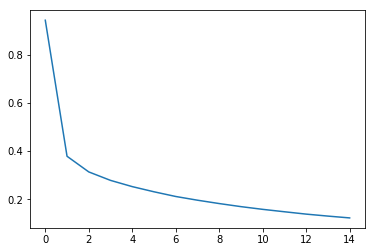

In [0]:
plt.plot(running_loss_history, label='Training Loss')

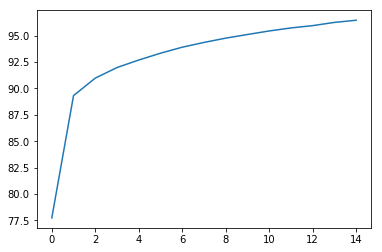

In [0]:
plt.plot(running_corrects_history, label='Training Accuracy')

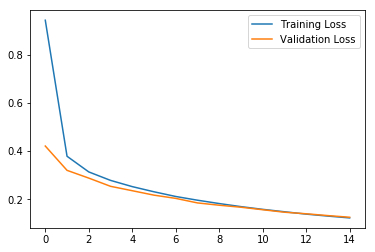

In [0]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()
plt.show()

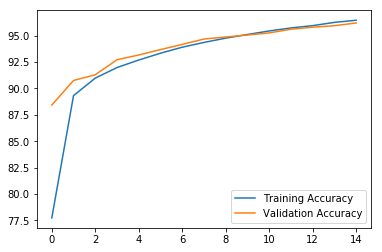

In [0]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()
plt.show()

<Response [200]>


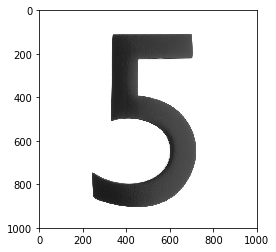

In [0]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

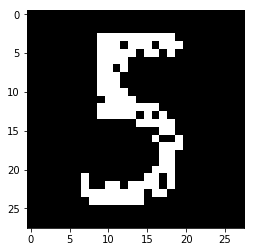

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1) 
print(pred.item())

5


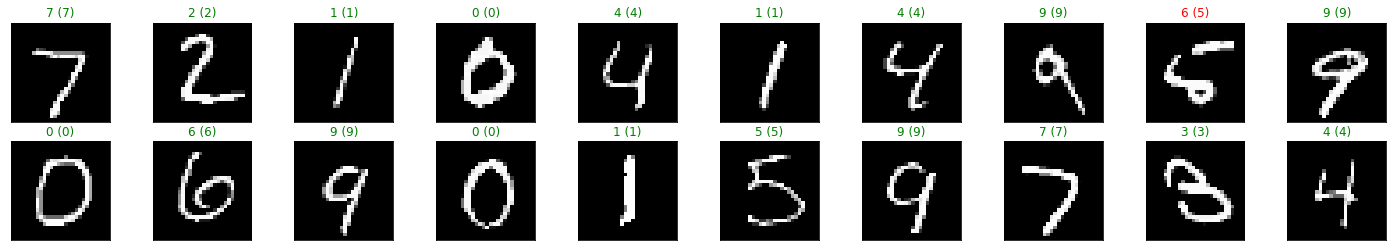

In [0]:
dataiter = iter(validation_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx]==labels[idx] else "red")) #her image için title